## Assignment IBM course: Supervised Machine Learning: Regression

### 1) Dataset Description

This notebook describes the exploratory data analysis for the Energy Effiency dataset available at the UCI machine learning database https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx, and also the construction of a regression model, which can predict the heating load using regression.

### Dataset Variables

* 1)X1 Relative Compactness
* 2)X2 Surface Area
* 3)X3 Wall Area
* 4)X4 Roof Area
* 5)X5 Overall Height
* 6)X6 Orientation
* 7)X7 Glazing Area
* 8)X8 Glazing Area Distribution
* 9)Y1 Heating Load - y variable (dependent)

* ps: Y2 Cooling Load - removed

Reference:
A. Tsanas, A. Xifara: 'Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools', Energy and Buildings, Vol. 49, pp. 560-567, 2012.

### 2) Importing needed modules and opening the dataset

In [1]:
#Importing needed modules
import pandas as pd
import numpy as np
import re
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#Saving the dataset into a pandas dataframe
#df = pd.read_excel ('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx')
df = pd.read_excel ('ENB2012_data.xlsx')

#Removing unnecessary variables from the dataset
df = df.drop (['Y2', 'Unnamed: 10', 'Unnamed: 11'], axis = 1)

#Renaming variables
df = df.rename (columns = {'X1':'Relative Compactness',
                           'X2':'Surface Area',
                           'X3':'Wall Area',
                           'X4':'Roof Area',
                           'X5':'Overall Height',
                           'X6':'Orientation',
                           'X7':'Glazing Area',
                           'X8':'Glazing Area Distribution',
                           'Y1':'Heating Load'})

#Showing the dataset
df

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84
...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48


### 3) Exploratory data analysis

In [2]:
#Relative Compactness, Surface Area, Wall Area, Roof Area, Overall Height, and Glazing Area - treated as continuous variable.
#Orientation, Glazing Area Distribution - treated as discrete variable             
#Heating Load - continuous variable dependent variable (y)                

df.dtypes

Relative Compactness         float64
Surface Area                 float64
Wall Area                    float64
Roof Area                    float64
Overall Height               float64
Orientation                    int64
Glazing Area                 float64
Glazing Area Distribution      int64
Heating Load                 float64
dtype: object

In [3]:
#Dataframe shape, to see number of variables (columns) 
#The dataset contains 768 observations and 9 variables, of which Heating Load is the dependent variable (y, or target)
df.shape

(768, 9)

In [4]:
#Searching for NA values
df.isnull().values.any() #No NA values. No need to dropna values

False

In [5]:
#Analyze general data;
gen_desc = df.describe().T
gen_desc = gen_desc.drop ('count', axis = 1)
gen_desc.rename (columns = {'50%':'Median',
                           'mean':'Mean',
                           'std':'Standard Deviation',
                           'min':'Minimum',
                           '25%':'Quantile 25',
                           '75%':'Quantile 75',
                           'max':'Maximum'}, inplace = True)

gen_desc['Range'] =  gen_desc['Maximum'] - gen_desc['Minimum']

gen_desc = np.round(gen_desc, decimals=3) ## round to better visualization
gen_desc

,Mean,Standard Deviation,Minimum,Quantile 25,Median,Quantile 75,Maximum,Range
Relative Compactness,0.764,0.106,0.62,0.682,0.75,0.830,0.98,0.36
Surface Area,671.708,88.086,514.50,606.375,673.75,741.125,808.50,294.00
Wall Area,318.500,43.626,245.00,294.000,318.50,343.000,416.50,171.50
Roof Area,176.604,45.166,110.25,140.875,183.75,220.500,220.50,110.25
Overall Height,5.250,1.751,3.50,3.500,5.25,7.000,7.00,3.50
Orientation,3.500,1.119,2.00,2.750,3.50,4.250,5.00,3.00
Glazing Area,0.234,0.133,0.00,0.100,0.25,0.400,0.40,0.40
Glazing Area Distribution,2.812,1.551,0.00,1.750,3.00,4.000,5.00,5.00
Heating Load,22.307,10.090,6.01,12.992,18.95,31.668,43.10,37.09


(array([ 20., 187., 153.,  39.,  39.,  59.,  83.,  83.,  59.,  46.]),
 array([ 6.01 ,  9.719, 13.428, 17.137, 20.846, 24.555, 28.264, 31.973,
        35.682, 39.391, 43.1  ]),
 <BarContainer object of 10 artists>)

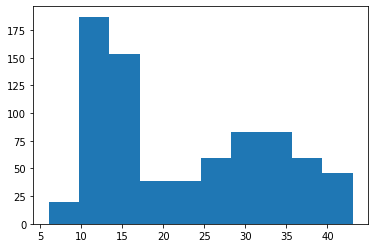

In [6]:
#Fires are relatively rare in the dataframe, so the area consumed by fire is skewed to zero.
#Confirming this tendency observed in the descriptive analysis (above).
%matplotlib inline
plt.hist (df['Heating Load'])

(array([ 16.,   4.,  77., 132., 139.,  31.,  56., 113., 110.,  90.]),
 array([2.07124993, 2.37715561, 2.68306128, 2.98896696, 3.29487263,
        3.6007783 , 3.90668398, 4.21258965, 4.51849533, 4.824401  ,
        5.13030668]),
 <BarContainer object of 10 artists>)

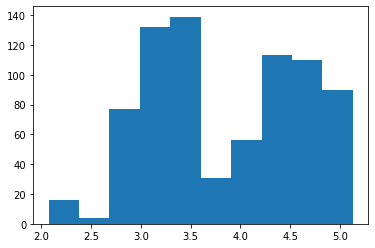

In [7]:
#boxcox_transform y
y_bc = boxcox(df['Heating Load'])[0] #Adding a small value to make boxcox possible
lambda_bc = boxcox(df['Heating Load'])[1]
plt.hist (y_bc)

In [8]:
#Seeing sample normality after boxcox transformation
print ('original', normaltest(df['Heating Load'])) #Non-normal distribution, given p < 0.05.

print ('boxcox_full', normaltest(y_bc)) #Non-normal distribution for boxcox transformed data, given p < 0.05;

#Y variable following the normal distribution is not required for regression. Although it usually provides better results.

original NormaltestResult(statistic=805.1379894106694, pvalue=1.4672597839006393e-175)
boxcox_full NormaltestResult(statistic=778.6176659406502, pvalue=8.420193749868054e-170)


### 4) Data wrangling and preparation

In [9]:
#Removing outliers
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] #No outlier

#Creating series and dataframes to the further analyses.
X = df.drop ('Heating Load', axis = 1)
y = df ['Heating Load']

### 5) Objectives

The objective of this assignment is to create models that can accurately predicts Heat load, by using linear regression.

Different models will be generated iteratively with cross validation strategy, in addition to grid search to find the best hyperameters to fit the model, including regularization. 

The model will be also evaluated, assessing error parameters, like RMSE, and R² metric for the train and test dataset, which allows detection of overfitting and underfitting. The best model will be selected based on the lowest RMSE, and highest R².

Investigate which features are most "impactful" to predict (affect) y variable.

### 6) Regression models construction

### Model 1- Standard scaled linear regression without regularization

In [10]:
#Due to the different scales in numeric variables, standard scaler is needed.
s = StandardScaler()

X_ss = pd.DataFrame (s.fit_transform(X))


#Defining K-fold strategy and regression algorithm
kf = KFold(shuffle=True, random_state=72018, n_splits=4)
lr = LinearRegression ()

#Running linear regression with k-fold cross validation strategy
lr_validation = []

for train_index, test_index in kf.split(X):
    
    #Train x test split
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    #Fitting data to a linear regression
    lr.fit(X_train, y_train)
    
    #Predicting y hat
    y_test_pred = lr.predict(X_test)
    y_train_pred = lr.predict(X_train)
    
    #Calculating R² and RMSE
    lr_validation.append (pd.Series ({'rmse_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                                      'rmse_test' : np.sqrt(mean_squared_error(y_test,  y_test_pred)),
                                      'r2_train' : r2_score(y_train, y_train_pred),
                                      'r2_test'  : r2_score(y_test,  y_test_pred)}))



#Seeing the validation results (R² and RMSE)
lr_validation = pd.DataFrame (lr_validation)
lr_validation.mean()

rmse_train    2.921524
rmse_test     2.967951
r2_train      0.916029
r2_test       0.913031
dtype: float64

### Model 2- Poynomial features standard scaled linear regression without regularization

In [11]:
#Converting to polynomial feature degree 2
pf = PolynomialFeatures(degree=2, include_bias=False)
s = StandardScaler()

X_pf = pd.DataFrame (pf.fit_transform(X))
X = pd.DataFrame (s.fit_transform(X_pf))

#Defining X and y

#Defining K-fold strategy and regression algorithm
kf = KFold(shuffle=True, random_state=72018, n_splits=4)
lr = LinearRegression ()

#Running linear regression with k-fold cross validation strategy
lr_validation = []

for train_index, test_index in kf.split(X):
    
    #Train x test split
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    #Fitting data to a linear regression
    lr.fit(X_train, y_train)
    
    #Predicting y hat
    y_test_pred = lr.predict(X_test)
    y_train_pred = lr.predict(X_train)
    
    #Calculating R² and RMSE
    lr_validation.append (pd.Series ({'rmse_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                                      'rmse_test' : np.sqrt(mean_squared_error(y_test,  y_test_pred)),
                                      'r2_train' : r2_score(y_train, y_train_pred),
                                      'r2_test'  : r2_score(y_test,  y_test_pred)}))


#Seeing the validation results (R² and RMSE)
lr_validation = pd.DataFrame (lr_validation)
lr_validation.mean() # Huge decrease in error and huge increase in R²

rmse_train    0.724195
rmse_test     0.759892
r2_train      0.994840
r2_test       0.994295
dtype: float64

### Model 3- Polynomial features standard scaled linear regression with L1 regularization, cross validation and grid search

In [12]:
#Due to the different scales in numeric variables, standard scaler is needed.
pf = PolynomialFeatures(degree=2, include_bias=False)
s = StandardScaler()

X_pf = pd.DataFrame (pf.fit_transform(X))
X = pd.DataFrame (s.fit_transform(X_pf))

#Defining K-fold strategy and regression algorithm
kf = KFold(shuffle=True, random_state=72018, n_splits=4)

#Creating a list of alphas
alphas = [1e-4, 1e-2, 1, 4, 10, 20]

#Running linear regression with k-fold cross validation strategy
r2_test = 0

for alpha in alphas:
    las = Lasso (alpha, max_iter = 10000)
    las_validation = []
    
    for train_index, test_index in kf.split(X):

        #Train x test split
        X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                            X.iloc[test_index, :], 
                                            y[train_index], 
                                            y[test_index])
        
        #Fitting data to a linear regression
        las.fit(X_train, y_train)
        
        #Predicting y hat
        y_test_pred = las.predict(X_test)
        y_train_pred = las.predict(X_train)
        
        #Calculating R² and RMSE
        las_validation.append (pd.Series ({'rmse_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                                           'rmse_test' : np.sqrt(mean_squared_error(y_test,  y_test_pred)),
                                           'r2_train' : r2_score(y_train, y_train_pred),
                                           'r2_test'  : r2_score(y_test, y_test_pred)}))

    #Seeing the validation results (R² and RMSE)
    las_validation = pd.DataFrame (las_validation)
    
    #identifying the best model
    if las_validation.mean()['r2_test'] > r2_test:
        r2_test = las_validation.mean()['r2_test']
        best_model_las = pd.DataFrame (las_validation.mean())
        best_model_las ['alpha'] = alpha
        final_las_model = las.fit(X_train, y_train) #Saving best model
        
#Seeing the best model
best_model_las #Slightly reduces error and slightly increase in R², when compared to the polynomial feature standard scaled model
#Best model has alpha hyperparameter of 0.0001

C:\Users\gabrielkytz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.421869653227397, tolerance: 5.81568279834375
  model = cd_fast.enet_coordinate_descent(
C:\Users\gabrielkytz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18.154798537026544, tolerance: 5.895422309930557
  model = cd_fast.enet_coordinate_descent(
C:\Users\gabrielkytz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.307830122956233, tolerance: 5.9267878429305565
  model = cd_fast.enet_coordinate_descent(
C:\Users\gabrielkytz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descen

,0,alpha
rmse_train,0.351124,0.0001
rmse_test,0.467400,0.0001
r2_train,0.998787,0.0001
r2_test,0.997841,0.0001


### Model 4- Polynomial features standard scaled linear regression with L2 regularization cross validation and grid search

In [13]:
#Due to the different scales in numeric variables, standard scaler is needed.
pf = PolynomialFeatures(degree=2, include_bias=False)
s = StandardScaler()

X_pf = pd.DataFrame (pf.fit_transform(X))
X = pd.DataFrame (s.fit_transform(X_pf))

#Defining K-fold strategy and regression algorithm
kf = KFold(shuffle=True, random_state=72018, n_splits=4)

#Creating a list of alphas
alphas = [1e-4, 1e-2, 1, 4, 10, 20]

r2_test = 0
#Running linear regression with k-fold cross validation strategy
for alpha in alphas:
    rid = Ridge (alpha)
    rid_validation = []

    for train_index, test_index in kf.split(X):

        #Train x test split
        X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                            X.iloc[test_index, :], 
                                            y[train_index], 
                                            y[test_index])
        
        #Fitting data to a linear regression
        rid.fit(X_train, y_train)
        
        #Predicting y hat
        y_test_pred = rid.predict(X_test)
        y_train_pred = rid.predict(X_train)

        #Calculating R² and RMSE
        rid_validation.append (pd.Series ({'rmse_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                                           'rmse_test' : np.sqrt(mean_squared_error(y_test,  y_test_pred)),
                                           'r2_train' : r2_score(y_train, y_train_pred),
                                           'r2_test'  : r2_score(y_test, y_test_pred)}))

    #Seeing the validation results (R² and RMSE)
    rid_validation = pd.DataFrame (rid_validation)
    
    #identifying the best model
    if rid_validation.mean()['r2_test'] > r2_test:
        r2_test = rid_validation.mean()['r2_test']
        best_model_rid = pd.DataFrame (rid_validation.mean())
        best_model_rid['alpha'] = alpha
        final_rid_model = rid.fit(X_train, y_train) #Saving best model
        
#Seeing the best model
best_model_rid

,0,alpha
rmse_train,0.166177,20
rmse_test,0.534076,20
r2_train,0.999728,20
r2_test,0.997152,20


### 7) Analyzing feature importance for the best model (Model 3)

In [18]:
pd.DataFrame(zip(df.columns, abs (final_las_model.coef_))).sort_values(by=1) #absolute importance

,0,1
5,Orientation,0.000000
7,Glazing Area Distribution,0.000000
8,Heating Load,0.000000
1,Surface Area,0.179783
4,Overall Height,0.654143
6,Glazing Area,1.541375
3,Roof Area,1.643476
0,Relative Compactness,4.636555
2,Wall Area,5.897008


In [19]:
pd.DataFrame(zip(df.columns, final_las_model.coef_)).sort_values(by=1) # direction of influence in y variable

,0,1
3,Roof Area,-1.643476
1,Surface Area,-0.179783
5,Orientation,0.000000
7,Glazing Area Distribution,0.000000
8,Heating Load,0.000000
4,Overall Height,0.654143
6,Glazing Area,1.541375
0,Relative Compactness,4.636555
2,Wall Area,5.897008


### 8) Discussion

1- We successfully created linear regression models to predict Heating Load based on the combination of 8 numeric variables (feature). Different linear models were created, by using polynomial features, standard scaler, L1 and L2 regularization. A grid search using different alpha parameters were performed for L1 and L2 regularization models.

2- The validation analysis showed that the best model, i.e. that with the greatest R² and lowest RMSE for the test set, is the model 3: polynomial features standard scaled linear regression with L1 regularization (alpha 0.0001), cross validation and grid search). This model presented 0.997841 of R² score, very close to the highest possible value (1), and a RMSE ver small, close to zero (lowest error value possible).

3- Both train and test sets presented high and similar values, suggesting that this model is not overfitted.

4- Model 3 is a very accurate regression model that can predict with elevated precision the value of Heating Load.

5- According to the the analyze of feature importance, Wall Area and Relactive Compactness are the features that exert most influence y variable (Heating Load). Orientation, Glazing Area Distribution, and Heating Load have no impact on y variable (Heating Load). When analyzing the direction of feature influence on y, Roof Area and Surface area are responsible for reducing Heating load, Overall Height, Glazing Area, Relative Compactness and Wall Area are responsible for increasing Heating load.

### 9) Perspectives

Given the R²value and RMSE calculated for Model 3 (Polynomial features standard scaled linear regression with L1 regularization, cross validation and grid search), very few or no adjustments in the model are necessary. The RMSE value (0.997841) for the test set is almost the maximum possible, 1. The RMSE (0.467400) is also the lowest possible, 0. 

Many other predictive models could be selected for this task, like neural networks, for example. However, given the great scores obtained in the validation step, it won't be necessary to use a more complex algorithm or collect more data to improve the model.

Other possible model could be constructed using the Cooling Load variable, as the y (dependent)variable. This dataset contains 2 possible y variables: Heating Load and Cooling Load, as suggested by the dataset's author (A. Tsanas, A. Xifara, 2012). All the predictive analysis were performed in this assignment using Heating Load, so Cooling Load was not included.